Requires notebook 0.

In [1]:
suppressPackageStartupMessages({
  library(dplyr)
  library(dataorganizer)
  library(devtools)
  library(cellAdmix)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [2]:
# load data
cell_annot <- prepare_nsclc_metadata(reps='one')
df <- prepare_nsclc_transcript_data(cell_annot,reps='one')

# converting back to px from um units
df$x <- (df$x * 1000) / 180
df$y <- (df$y * 1000) / 180
df$z <- (df$z * 1000) / 800

df <- df[,c('x_local_px','y_local_px','z','cell','fov','celltype','gene')]
colnames(df) <- c('x','y','z_index','cell','fov','celltype','gene')

# # remove z slices that we don't have images for
df <- df[df$z %in% c(0:8),]

In [3]:
score_params <- list(
  sep_type = "pairwise_max",
  compare_type = "cross_groups", # 'cross_groups' (i.e., admix-pure vs pure-pure) or 'same_groups' (i.e.,admix-admix vs pure-pure)
  norm_scores = FALSE, # to normalize each pair's membrane signal by distance between molecules
  same_z = TRUE,
  balance_dists = TRUE, # to balance molecule pair distance distributions between admix and native groups
  min_mols = 5, # require at least this many molecule pairs of each type admix/native to test a cell
  downsamp_cells_to = NULL, # downsample number of cells per fov to test
  downsamp_pairs_to = NULL # downsample number of molecule pairs per z slice to test if above this threshold
)

In [4]:
focal_cell_type <- 'fibroblast'

df_markers <- load_markers_nsclc()
colnames(df_markers) <- c('gene','ct')
df_markers <- df_markers[df_markers$ct %in% c("malignant","macrophage","fibroblast"),]
df_markers$is_admixture <- df_markers$ct != focal_cell_type

ndx_match <- match(df$gene,df_markers$gene)
df$is_admixture <- df_markers[ndx_match,'is_admixture']
df <- df[!is.na(df$is_admixture),]

In [9]:
devtools::load_all()

ℹ Loading cellAdmixNotebooks


In [10]:
scores <- get_scores_all_fov(df, score_params, load_images_nsclc, ct_test=focal_cell_type, n.cores=10)

In [12]:
print(t.test(log(scores), mu = 0, alternative = "greater"))
sum(scores>1)/length(scores)
sum(scores<1)/length(scores)


	One Sample t-test

data:  log(scores)
t = 33.571, df = 7527, p-value < 2.2e-16
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 0.0811103       Inf
sample estimates:
 mean of x 
0.08528968 



[1] 0.629915

[1] 0.3015409

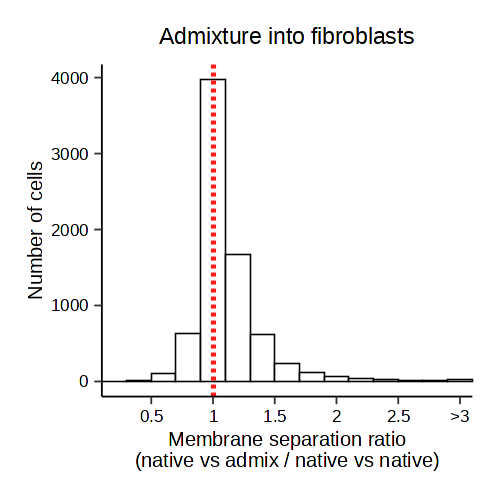

In [13]:
options(repr.plot.width = 2.5, repr.plot.height = 2.5, repr.plot.res = 200)

p <- plot_scores(scores,title='Admixture into fibroblasts',score_params,
                 log_transform=FALSE,binwidth=.2,capval=3)
p

In [14]:
pdf(OutputPath("nsclc_membrane_sep.pdf"), useDingbats=FALSE, width=1.85, height=1.85)
p
dev.off()

png 
  2